In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station= Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
#most_recent_date = session.query(func.max(Measurement.date)).scalar()
session.query(Measurement.date).order_by(desc(Measurement.date)).first()
#most_recent_date=dt.datetime(most_recent_date)


('2017-08-23',)

In [10]:
#converting string date to a date format
most_recent_date=session.query(Measurement.date).order_by(desc(Measurement.date)).first()
most_recent_date=most_recent_date[0]
most_recent_date=datetime.strptime(most_recent_date, '%Y-%m-%d').date()


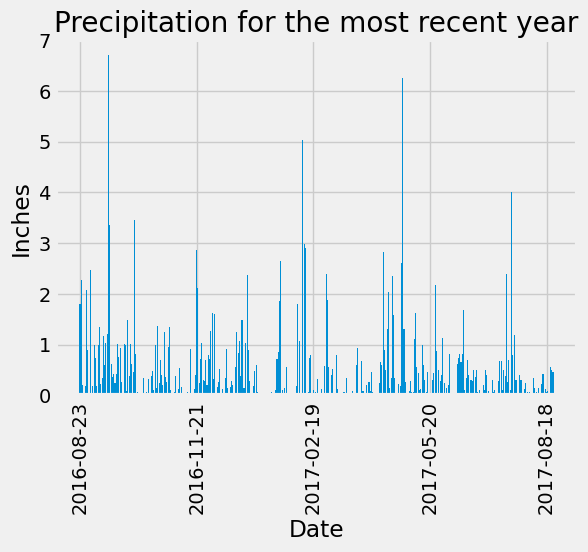

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
previous_year_date= most_recent_date- dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
#query = "select([Measurement]).where(Measurement.c.date.between(previous_year_date, most_recent_date))"
result = session.query(Measurement.date,Measurement.prcp)\
                .where(Measurement.date.between(previous_year_date, most_recent_date))\
                .order_by(desc(Measurement.date))   

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df=pd.DataFrame(result)
precipitation_df.rename(columns={'prcp': 'precipitation'}, inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date', ascending=True)
precipitation_df.set_index('date')

#Find the xticks (quarters)
mindate=datetime.strptime(precipitation_df['date'].min(), '%Y-%m-%d').date()
maxdate=datetime.strptime(precipitation_df['date'].max(), '%Y-%m-%d').date()
quarters=[]

quarters.append(mindate.strftime("%Y-%m-%d"))
run = 'y'
while run == 'y':
    mindate= mindate+ dt.timedelta(days=90)
    if mindate>maxdate:
        run='no'
    else:
        quarters.append(mindate.strftime("%Y-%m-%d"))

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precipitation_df['date'], precipitation_df['precipitation'])
plt.ylabel("Inches")
plt.xlabel("Date")
plt.title("Precipitation for the most recent year")
plt.tight_layout()
plt.ylim(0, 7)
plt.xticks(quarters)
plt.xticks(rotation=90) 
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Measurement.station.distinct())).scalar()


9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)) \
                        .group_by(Measurement.station) \
                        .order_by(func.count(Measurement.station).desc()) \
                        .all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#find the most active station 
most_active_station=station_counts[0][0]

list(session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
        .where(Measurement.station==most_active_station))


[(54.0, 85.0, 71.66378066378067)]

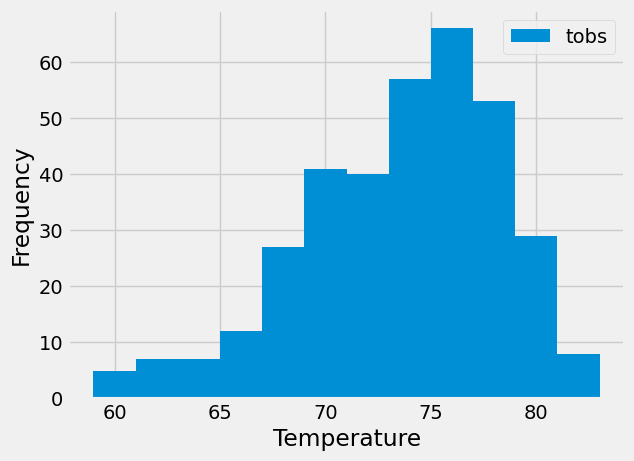

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_df=pd.DataFrame(session.query(Measurement.tobs)\
                             .where(Measurement.station==most_active_station)\
                             .where(Measurement.date.between(previous_year_date, most_recent_date))
                   )
temperature_df.plot.hist(bins=12)              
plt.xlabel('Temperature')
plt.ylabel('Frequency')
# Display the plot
plt.show()
        

# Close Session

In [17]:
# Close Session
session.close()